In [2]:
import matplotlib.pyplot as plt
import numpy as np
from skimage.io import imread
from skimage.color import rgb2gray
from skimage.filters import threshold_otsu
from skimage.filters import gaussian

import matplotlib.patches as mpatches
from skimage.measure import label, regionprops
from skimage.util import invert
from scipy.spatial.distance import euclidean

import numpy as np
from skimage.draw import polygon_perimeter
from commonfunctions import *

import cv2
import numpy as np
from commonfunctions import *

from skimage.measure import compare_ssim
import imutils
from imutils import contours


In [3]:

alphabetics_dict = {}
Alpha_numeric_list=['A','B','C','D','E','F','G','H','I','G','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z',
                    '0','1','2','3','4','5','6','7','8','9',
                    'a','b','c','d','e','f','g','h','i','g','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z']

# import image
def read_image(image):
    image = cv2.imread(image)
    return image

#read letters images and save their histograms
def readletters():
    for i in range(len(Alpha_numeric_list)):
        alphabetics_dict.update( { Alpha_numeric_list[i] : histogram(
            rgbtogray(read_image( "alphanumeric/" + Alpha_numeric_list[i] + ".png"))) } )

    return

# find contours and sort them
def find_contours(img_dilation):
    ctrs, hier = cv2.findContours(img_dilation.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    sorted_ctrs = sorted(ctrs, key=lambda ctr: cv2.boundingRect(ctr)[0])
    return sorted_ctrs

def extract_digits_and_symbols(image, charCnts, minW=5, minH=15):
    # grab the internal Python iterator for the list of character
    # contours, then  initialize the character ROI and location
    # lists, respectively
    charIter = charCnts.__iter__()
    rois = []
    locs = []

    # keep looping over the character contours until we reach the end
    # of the list
    while True:
        try:
            # grab the next character contour from the list, compute
            # its bounding box, and initialize the ROI
            c = next(charIter)
            (cX, cY, cW, cH) = cv2.boundingRect(c)
            roi = None

            # check to see if the width and height are sufficiently
            # large, indicating that we have found a digit
            if cW >= minW and cH >= minH:
                # extract the ROI
                roi = image[cY:cY + cH, cX:cX + cW]
                rois.append(roi)
                locs.append((cX, cY, cX + cW, cY + cH))

            # otherwise, we are examining one of the special symbols
            else:
                # MICR symbols include three separate parts, so we
                # need to grab the next two parts from our iterator,
                # followed by initializing the bounding box
                # coordinates for the symbol
                parts = [c, next(charIter), next(charIter)]
                (sXA, sYA, sXB, sYB) = (np.inf, np.inf, -np.inf,-np.inf)

                # loop over the parts
                for p in parts:
                    # compute the bounding box for the part, then
                    # update our bookkeeping variables
                    (pX, pY, pW, pH) = cv2.boundingRect(p)
                    sXA = min(sXA, pX)
                    sYA = min(sYA, pY)
                    sXB = max(sXB, pX + pW)
                    sYB = max(sYB, pY + pH)

                # extract the ROI
                roi = image[sYA:sYB, sXA:sXB]
                rois.append(roi)
                locs.append((sXA, sYA, sXB, sYB))

        # we have reached the end of the iterator; gracefully break
        # from the loop
        except StopIteration:
            break

    # return a tuple of the ROIs and locations
    return (rois, locs)




A


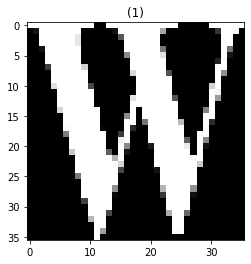

B


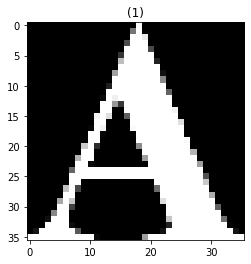

C


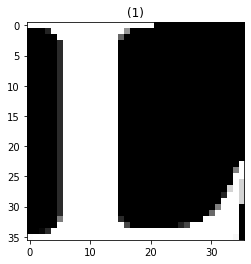

D


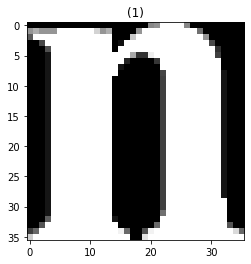

E


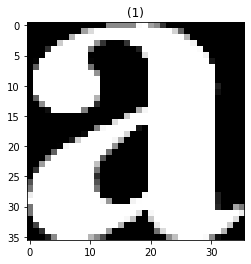

F


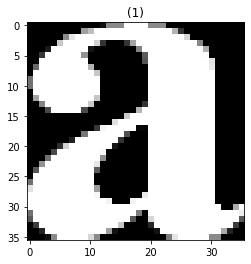

G


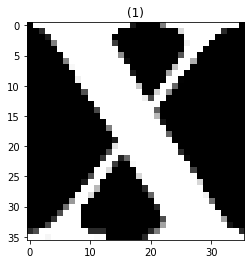

H


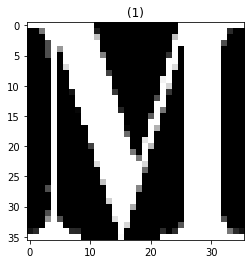

I


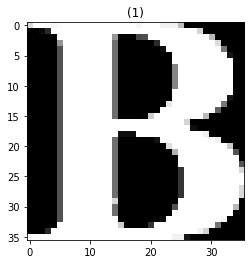

K


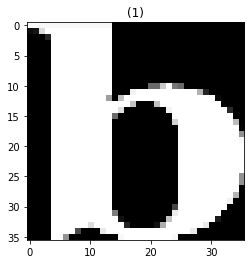

L


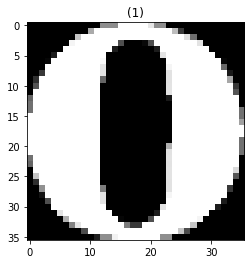

M


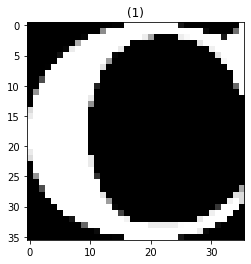

N


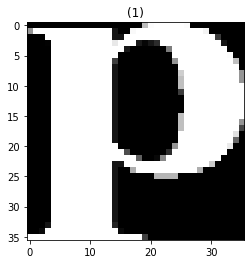

O


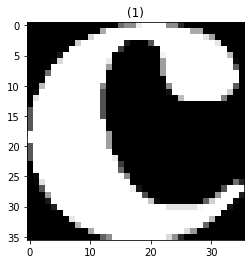

P


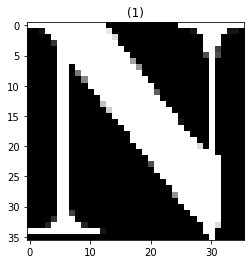

Q


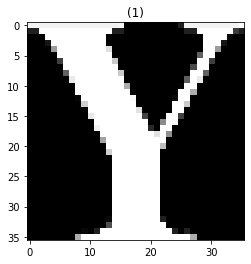

R


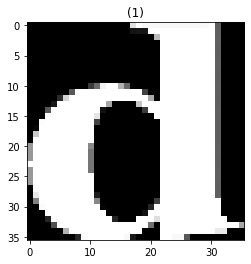

S


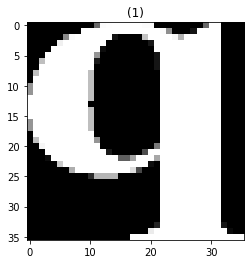

T


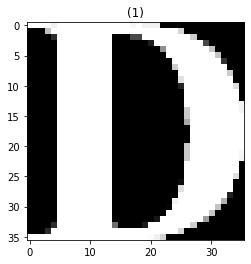

U


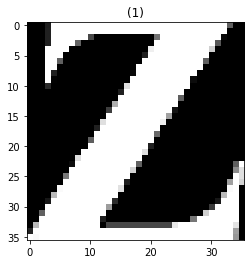

V


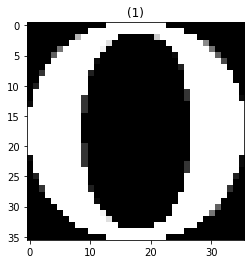

W


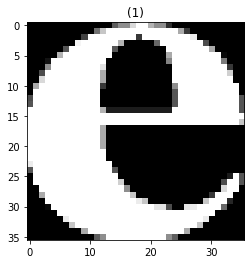

X


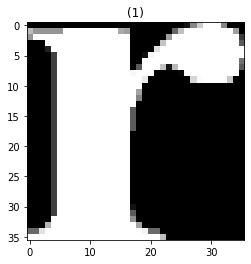

Y


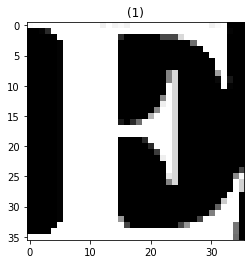

Z


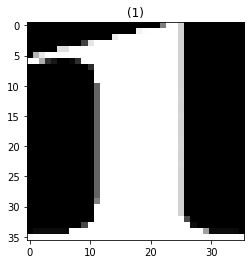

0


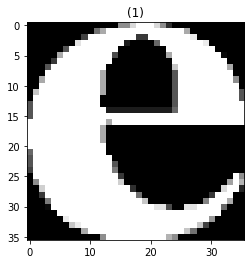

1


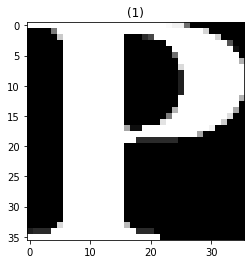

2


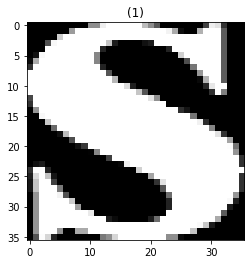

3


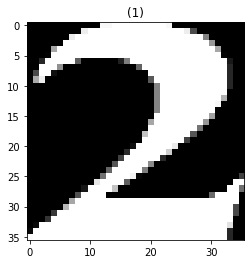

4


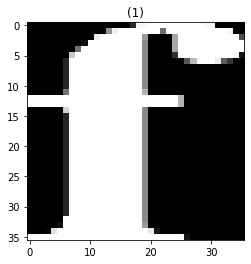

5


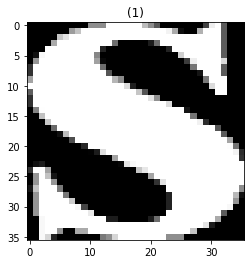

6


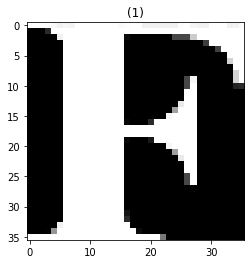

7


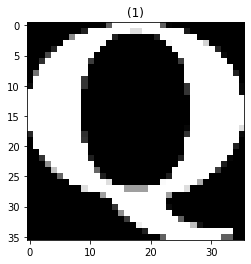

8


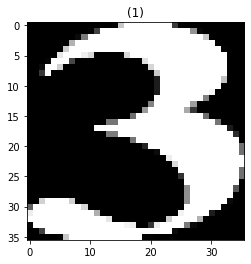

9


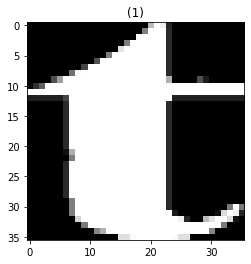

a


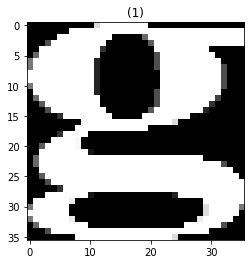

b


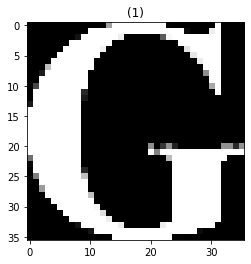

c


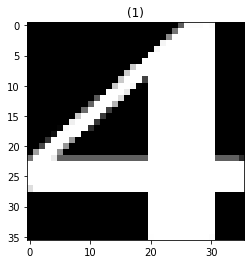

d


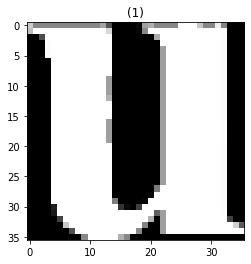

e


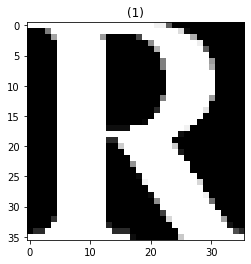

f


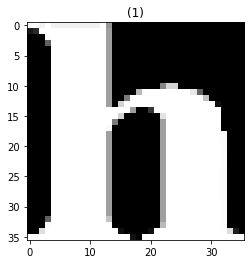

g


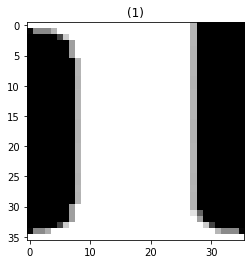

h


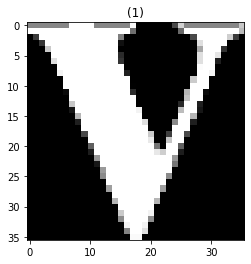

i


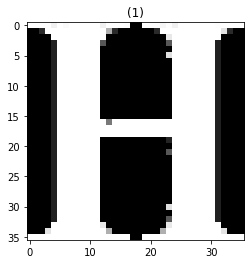

k


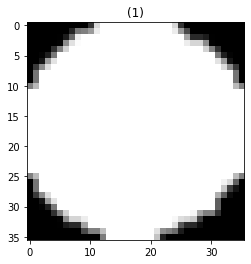

l


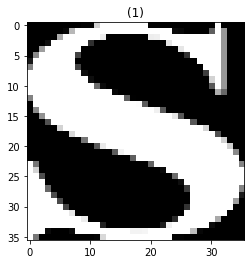

m


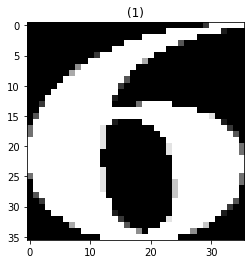

n


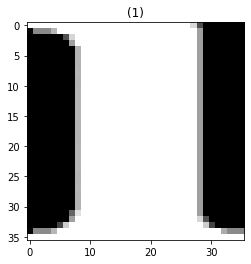

o


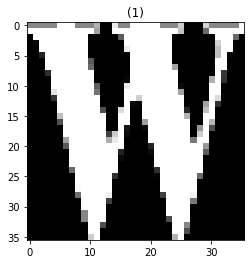

p


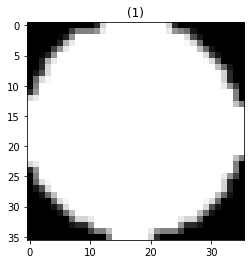

q


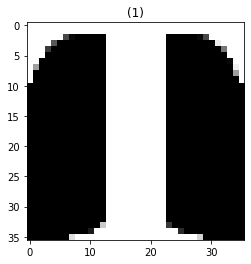

r


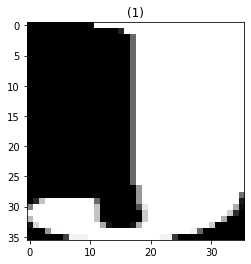

s


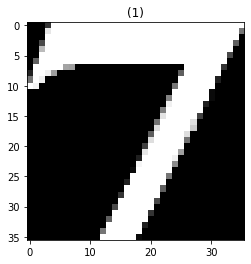

t


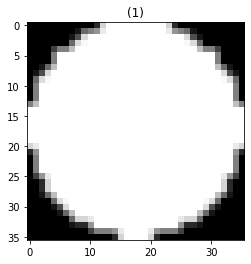

u


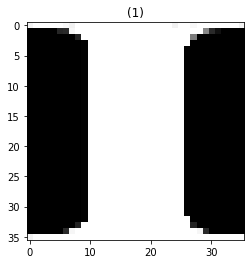

v


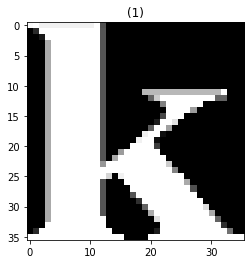

w


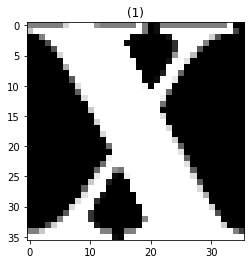

x


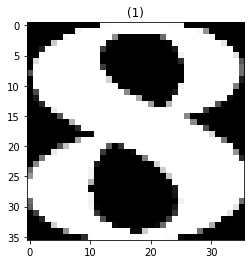

y


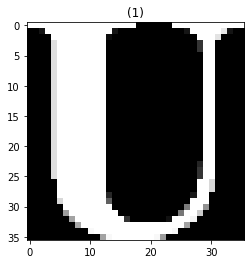

z


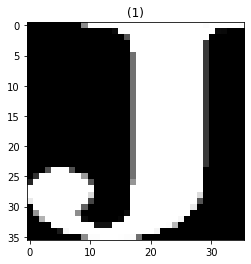

In [10]:

ref = read_image('alphabets.jpg')
ref = cv2.cvtColor(ref, cv2.COLOR_BGR2GRAY)
ref = imutils.resize(ref, width=2000)
ref = cv2.threshold(ref, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]

# find contours in the MICR image (i.e,. the outlines of the
# characters) and sort them from left to right
refCnts = cv2.findContours(ref.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
refCnts = imutils.grab_contours(refCnts)
refCnts = contours.sort_contours(refCnts, method="left-to-right")[0]

# extract the digits and symbols from the list of contours, then
# initialize a dictionary to map the character name to the ROI
refROIs = extract_digits_and_symbols(ref, refCnts,minW=10, minH=20)[0]
# loop over the reference ROIs
# for (name, roi) in zip(alphabetics_dict, refROIs):
#     # resize the ROI to a fixed size, then update the characters
#     # dictionary, mapping the character name to the ROI
#     print("finish111111")

#     roi = cv2.resize(roi, (36, 36)) 
#     #print(roi)
#     alphabetics_dict[name] = roi
for (name,roi) in zip(Alpha_numeric_list, refROIs):
    #print("her")
    roi=cv2.resize(roi,(36, 36))
    alphabetics_dict[name] = roi

for key in alphabetics_dict:
    print(key)
    show_images([alphabetics_dict[key]])